In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from evolvepro.src.data import load_dms_data
from evolvepro.src.evolve import directed_evolution_simulation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# load embeddings
embedding_df = pd.read_csv("output/dms/embeddings/jones_esm1b_t33_650M_UR50S.csv")
embedding_df = embedding_df.rename(columns={embedding_df.columns[0]: "mutation"})
wt_embedding_df = pd.read_csv("output/dms/embeddings/jones_WT.csv")
wt_embedding_df = wt_embedding_df.iloc[:, 1:]

# load labels
labels_df = pd.read_csv("output/dms/labels/jones_labels.csv")

In [3]:
wt_array = wt_embedding_df.iloc[0][1:]

In [4]:
high_activity_mutants = labels_df[labels_df["activity_binary_95p"]==1]["variant"].to_list()

In [5]:
high_activity_embedding_df = embedding_df[embedding_df["mutation"].isin(high_activity_mutants)]

In [6]:
single_aa_delta = wt_embedding_df.iloc[0] - high_activity_embedding_df.iloc[0, 1:]
single_aa_delta = single_aa_delta.to_list()

<Axes: ylabel='Count'>

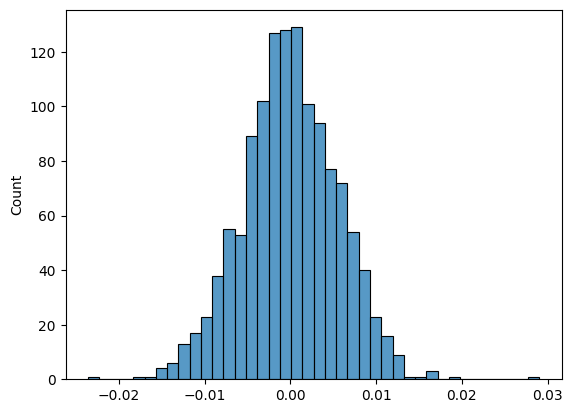

In [7]:
# plot the distribution of all delta 
sns.histplot(single_aa_delta)

In [21]:
# calculating sum of all deltas
delta_sum = [0] * 1280

for i in range(0, high_activity_embedding_df.shape[0]):
    # calculate row delta
    delta = abs(wt_embedding_df.iloc[0] - high_activity_embedding_df.iloc[0, 1:])
    delta = delta.to_list()
    # add to sum
    #delta_sum = [a_i + b_i for a_i, b_i in zip(delta, delta_sum)]
    delta_sum = np.add(delta, delta_sum)


<function matplotlib.pyplot.show(close=None, block=None)>

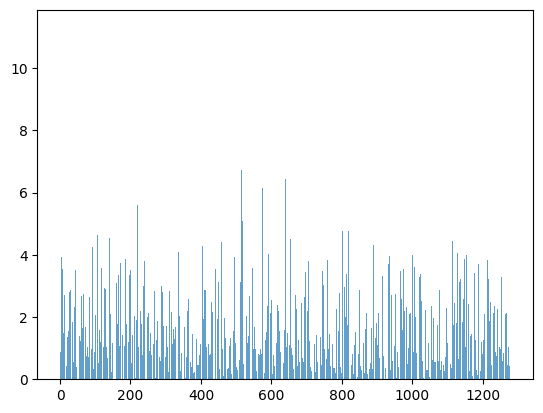

In [22]:
import matplotlib.pyplot as plt

x = range(len(delta_sum))
plt.bar(x, delta_sum, align='center', alpha=0.7)
plt.show

<Axes: ylabel='Count'>

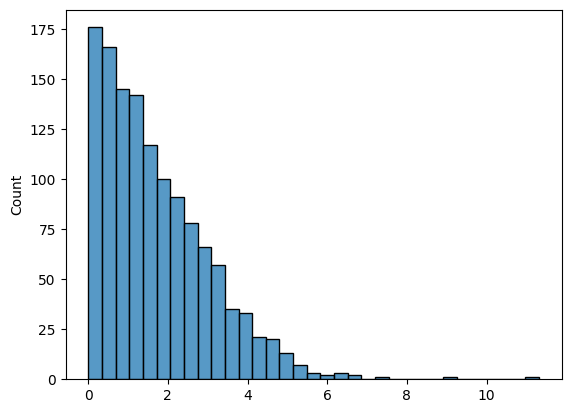

In [23]:
sns.histplot(delta_sum)

In [98]:
# running random forest and saving iterative predictions

#TODO: make this into a function

# load dataset
dataset_name = "jones"
model_name = "esm1b_t33_650M_UR50S"
embeddings_path = "output/dms/embeddings"
labels_path = "output/dms/labels"
embeddings_file_type = "csv"
embeddings_type_pt = "average"
embeddings, labels = load_dms_data(dataset_name, model_name, embeddings_path, labels_path, embeddings_file_type, embeddings_type_pt)

output_dir = "output/embedding_projections_test" 

all_predictions = []

iteration_old = None
for iter in range(0, 20):
    if iter == 0:
        # first iteration: randomly select mutants
        selected_variants = np.random.choice(
            labels.loc[labels['variant'] != 'WT', 'variant'],
            size=10, # number of mutants per round
            replace=False
        )
        iteration_old = pd.DataFrame({'iteration': iter, 'variant': selected_variants})
    else:
        # subsequent iterations: train Random Forest and predict on unselected variants
        selected_variants = set(iteration_old['variant'])

        # select embeddings and labels based on variant names
        selected_mask = embeddings.index.isin(selected_variants)

        # split data into training and prediction sets
        X_train = embeddings[selected_mask]
        y_train = labels.loc[selected_mask, 'activity_scaled']

        X_predict = embeddings[~selected_mask]
        variants_to_predict = X_predict.index.tolist()

        # train random forest model
        model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
                                      max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                      n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
                                      max_samples=None)
        model.fit(X_train, y_train)

        # make predictions
        predictions = model.predict(X_predict)

        # save predictions
        df_predictions = pd.DataFrame({
            'iteration': iter,
            'variant': variants_to_predict,
            'predicted_activity': predictions
        })

        # save prediction for this iteration
        all_predictions.append(df_predictions)

        # select the top variants for next iteration
        top_variants = df_predictions.sort_values(by='predicted_activity', ascending=False)
        selected_variants = top_variants.head(10)['variant'].tolist()

        # update iteration_old with the selected variants
        iteration_old = pd.concat(
            [iteration_old, pd.DataFrame({'iteration': iter, 'variant': selected_variants})],
            ignore_index=True
        )

final_predictions = pd.concat(all_predictions, ignore_index=True)

output_file = os.path.join(output_dir, "all_iterations_predictions.csv")
final_predictions.to_csv(output_file, index=False)

Embeddings and labels are aligned


<function matplotlib.pyplot.show(close=None, block=None)>

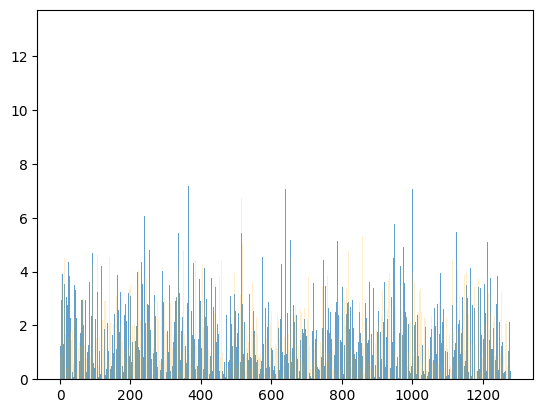

In [99]:
# read in all iteration predictions
iteration_predictions_df = pd.read_csv("output/embedding_projections_test/all_iterations_predictions.csv")

# for each iteration
iteration_data = iteration_predictions_df[iteration_predictions_df["iteration"] == 19] # limiting to last step for now
iteration_data = iteration_data.sort_values(by="predicted_activity", ascending=False)
selected_variants = top_variants.head(390)['variant'].tolist()

high_activity_variant_df = embedding_df[embedding_df["mutation"].isin(selected_variants)]


# calculating sum of all deltas
variant_delta_sum = [0] * 1280

for i in range(0, high_activity_variant_df.shape[0]):
    # calculate row delta
    delta = abs(wt_embedding_df.iloc[0] - high_activity_variant_df.iloc[0, 1:])
    delta = delta.to_list()
    # add to sum
    #delta_sum = [a_i + b_i for a_i, b_i in zip(delta, delta_sum)]
    variant_delta_sum = np.add(delta, variant_delta_sum)


import matplotlib.pyplot as plt

x = range(len(variant_delta_sum))
plt.bar(x, variant_delta_sum, align='center', alpha=0.7)
plt.bar(x, delta_sum, align='edge', color='orange', alpha=0.2)
plt.show

In [100]:
ranked_delta_sum = np.argsort(delta_sum)[::-1]
ranked_delta_sum[0:30]

array([ 659,  908,  987,  515,  442,  640,  821, 1274,  575,    5, 1172,
        588,  220,  405,  882,   76,  473,  788,  858,   59,  879,  518,
        661,   88,   23,    6,  967,  693,  436, 1241])

In [101]:
ranked_variant_delta_sum = np.argsort(variant_delta_sum)[::-1]
ranked_variant_delta_sum[0:10]

array([ 659,  987,  365,  298,  640, 1001,  821, 1274, 1146, 1170])